In [6]:
import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt
from itertools import combinations
from time import time

## FP-growth Algorithm Implementation

In [7]:
# Tree Node Class
class node:
    # initialization function
    def __init__(self, key, value, parent):
        self.key = key
        self.value = value
        self.parent = parent
        self.children = {}
        self.link = None
    # add value
    def add(self, value):
        self.value += value
    # add child
    def addChild(self, ckey, cnode):
        self.children[ckey] = cnode
    # print function
    def debug(self, blank=1):
        print(' '*blank, self.key,' ',self.value, )
        for child in self.children.values():
            child.debug(blank+1)
    # print link
    def debugLink(self):
        if(self.link!=None):
            print(self.link.key)
            self.link.debugLink();

In [8]:
# load dataset from local folder
dataPD = pd.read_excel("./AS5 supermarket.xlsx")
dataNamePD = pd.read_excel("./AS5 supermarket_attribute_name.xlsx")

PS: Be careful that these 2 files in local fold.

In [9]:
# convert dataset to list
dataNP = np.matrix(dataPD).tolist()
dataName = np.matrix(dataNamePD).tolist()

In [10]:
# only consider the bought items
data = []
for i in range(len(dataNP)):
    tmp = []
    for j in range(len(dataNP[i])):
        if dataNP[i][j] == 1:
            tmp.append(j)
    data.append(tmp)
dataName = [[0, 'department1'],]+dataName # add the missed first item
maxm=0
for i in data:
    for j in i:
        if j>maxm: maxm = j
print('max possible items:',maxm)

max possible items: 212


In [11]:
# tree builder function: scan dataset twice
def refreshTree(itemsInTrans, subTree, frequentHeadTableDict, count=1):
    if itemsInTrans[0] in subTree.children: subTree.children[itemsInTrans[0]].add(count)
    else:
        newNode = node(itemsInTrans[0],count,subTree)
        subTree.addChild(itemsInTrans[0], newNode)
        if frequentHeadTableDict[itemsInTrans[0]][1] == None:
            frequentHeadTableDict[itemsInTrans[0]][1] = subTree.children[itemsInTrans[0]]
        else:
            NodeToAdd = frequentHeadTableDict[itemsInTrans[0]][1]
            # only considering adding when dealing new node!
            while(NodeToAdd.link != None):
                NodeToAdd = NodeToAdd.link
            NodeToAdd.link = subTree.children[itemsInTrans[0]]
    if len(itemsInTrans)>1: refreshTree(itemsInTrans[1::], subTree.children[itemsInTrans[0]], frequentHeadTableDict, count)

def buildTree(dataSet, maxItemID, countList, minfreq):
    minFreq = minfreq
    itemIDs = list(range(maxItemID+1)) # select biggest id = 212
    itemOccurs = list(np.zeros(len(itemIDs)))
    for transI in range(len(dataSet)):
        trans = dataSet[transI]
        for itemID in trans:
            itemOccurs[itemID] += int(countList[transI])
    headTable = [[ele[1],ele[0]] for ele in reversed(sorted(zip(itemOccurs,itemIDs)))]
    frequentHeadTable = []
    for item in headTable:
        if item[1] >= minFreq: frequentHeadTable.append(item)
    if [ele for ele in headTable if ele[1]>0] == []: return None, None, None
    root = node('{}',1, None)
    frequentHeadTableToDict = []
    for ele in frequentHeadTable:
        frequentHeadTableToDict.append([ele[0],[ele[0],None]])
    frequentHeadTableDict = dict(frequentHeadTableToDict)
    for transID in range(len(dataSet)):
        trans = dataSet[transID]
        itemsInTrans = []
        for ele in frequentHeadTable:
            if(ele[0]) in trans: itemsInTrans.append(ele[0])
        if(itemsInTrans != []): refreshTree(itemsInTrans, root, frequentHeadTableDict, countList[transID])
    return root, frequentHeadTable, frequentHeadTableDict

### By 'FP-growth for discovering frequent itemsets without candidate generation' on book shown below:
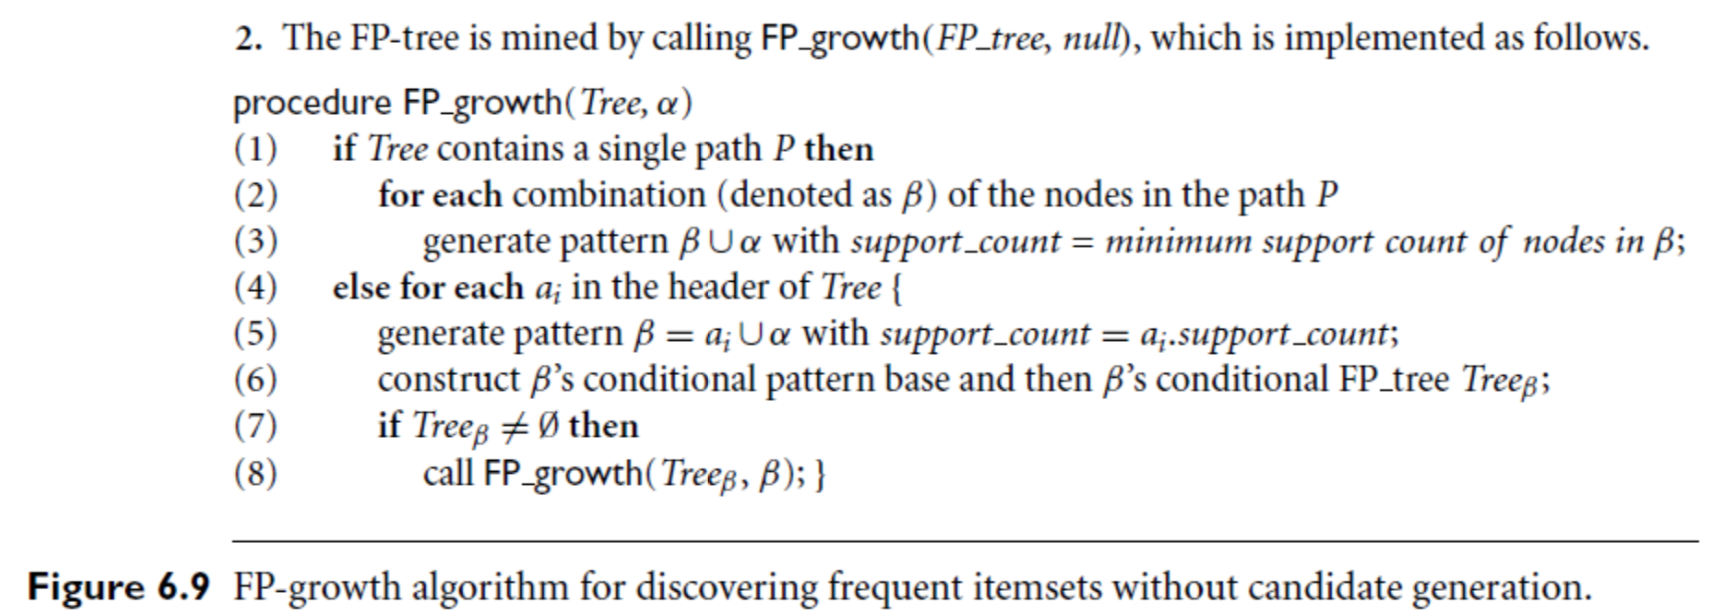
### We can serive the following mining function: 

In [12]:
# The mining function's helper
def findCondPs(currentNode):
    CondPs = {}
    while currentNode != None:
        oneSinglePath = []
        tmpNode = currentNode.parent
        while tmpNode.parent != None:
            oneSinglePath.append(tmpNode.key)
            tmpNode = tmpNode.parent
        if oneSinglePath != []: CondPs[frozenset(oneSinglePath)] = currentNode.value
        currentNode = currentNode.link
    return CondPs

# The mining function
def mining(frequentHeadTable, frequentHeadTableDict, freItemSet, freItemCounts, prefix, maxm, minfreq):
    freItem1 = [ele[0] for ele in frequentHeadTable]
    tmpDict = dict(frequentHeadTable)
    for newBase in freItem1:
        nextBases = prefix.copy()
        nextBases.add(newBase)
        freItemCounts[frozenset(nextBases)] = tmpDict[newBase]
        freItemSet.append(nextBases)
        CondPs = findCondPs(frequentHeadTableDict[newBase][1])
        newDataFrozen = list(CondPs.keys())
        newData = [list(ele) for ele in newDataFrozen]
        newCounts = list(CondPs.values())
        theRoot_, theFrequentHeadTable_, theFrequentHeadTableDict_ = buildTree(newData, maxm, newCounts, minfreq)
        if theFrequentHeadTableDict_ != None: mining(theFrequentHeadTable_, theFrequentHeadTableDict_, freItemSet, freItemCounts, nextBases, maxm, minfreq)
    return freItemSet, freItemCounts

In [13]:
# Main function
freItemSetObject = []
freItemCountsObject = {}
startTime1 = time()
theRoot, theFrequentHeadTable, theFrequentHeadTableDict = buildTree(data,maxm,list(np.ones(len(data))),1100)
internTime1 = time()
_1,_2 = mining(theFrequentHeadTable, theFrequentHeadTableDict,freItemSetObject,freItemCountsObject,set([]), maxm ,1100)
stopTime1 = time()
print('Execution Time of FP-growth tree building:',internTime1-startTime1)
print('Execution Time of FP-growth frequent pattern mining:',stopTime1-internTime1)


Execution Time of FP-growth tree building: 5.5792200565338135
Execution Time of FP-growth frequent pattern mining: 0.5906140804290771


In [14]:
print('10 Most frequent 2-itemset patterns mined by FP-growth')
count = 0
for itemSet in freItemSetObject:
    if len(itemSet)==2 and int(freItemCountsObject[frozenset(itemSet)])>1920:
        tmp = list(itemSet).copy()
        tmp.sort()
        print(tmp, int(freItemCountsObject[frozenset(itemSet)]))
        count+=1
print('Total number of 2-k frequent patterns:',count)

10 Most frequent 2-itemset patterns mined by FP-growth
[12, 82] 2325
[12, 85] 2298
[82, 85] 2207
[12, 60] 2337
[60, 82] 2038
[60, 85] 2025
[12, 13] 2191
[13, 85] 1949
[12, 31] 2129
[12, 17] 2083
Total number of 2-k frequent patterns: 10


## Apriori Algorithm Implementation:

In [15]:
def valid(l1, l2):
    if len(l1) != len(l2): return False
    for i in range(len(l1)):
        if i == (len(l1)-1): return l1[i] < l2[i]
        else:
            if l1[i] != l2[i]: return False

def no_infrequent_subset(c, laskLk, k):
    lastk = k-1
    comb = combinations(c, lastk)
    for s in comb:
        s_list = list(s)
        if k == 2:
            if set(s) < set(laskLk) == False: return False
        else:
            if frozenset(s_list) not in laskLk: return False
    return True 

def apriori_gen(lastLk, k):
    Ck = {}
    for l1_ in lastLk:
        l1=[]
        if k==2: l1 = [l1_]
        else:
            l1 = list(l1_)
            l1.sort()
        for l2_ in lastLk:
            l2=[]
            if k==2: l2 = [l2_]
            else:
                l2 = list(l2_)
                l2.sort()
            if valid(l1,l2):
                c = l1.copy()
                c.append(l2[-1])
                c.sort()
                if no_infrequent_subset(c, lastLk, k):
                    Ck[frozenset(c)] = Ck.get(frozenset(c),0)
    return Ck

# The mining function
def Apriori(data, minFreq, result):
    frequentPatterns = {}
    for trans in data:
        for item in trans:
            frequentPatterns[item]=frequentPatterns.get(item,0)+1
    Lk = {k:v for (k,v) in frequentPatterns.items() if v>=minFreq}
    k = 2
    while(Lk!={}):
        if k == 2: 
            for ele in [[k,v] for (k,v) in Lk.items()]:
                result.append(ele)
        else:
            for ele in [[list(k),v] for (k,v) in Lk.items()]:
                result.append(ele)
        tmp = {}
        Lk_list = [k for (k,v) in Lk.items()]
        Ck = apriori_gen(Lk_list, k) #returns dict
        for trans in data:
            for key in [k for (k,v) in Ck.items()]:
                if set(key)<=set(trans): tmp[key] = tmp.get(key,0)+1
        Lk = {k:v for (k,v) in tmp.items() if v>=minFreq}
        k += 1

In [16]:
result = []
startTime2 = time()
Apriori(data,1100,result)  
stopTime2 = time()
print('Execution Time of Apriori:',stopTime2-startTime2)

Execution Time of Apriori: 4.771154165267944


In [17]:
# query the wanted result from 'result':
print('10 Most frequent 2-itemset patterns mined by Apriori')
count = 0
for ele_ in [ele for ele in result if type(ele[0])!=int and len(ele[0])==2 and ele[1]>1920]: 
    ele_[0].sort()
    print(ele_[0],ele_[1]); count+=1
print(count)

10 Most frequent 2-itemset patterns mined by Apriori
[12, 13] 2191
[12, 17] 2083
[12, 31] 2129
[12, 60] 2337
[12, 82] 2325
[12, 85] 2298
[13, 85] 1949
[60, 82] 2038
[60, 85] 2025
[82, 85] 2207
10


### Apriori Algorithm Pseudo Code on Textbook for Reference:
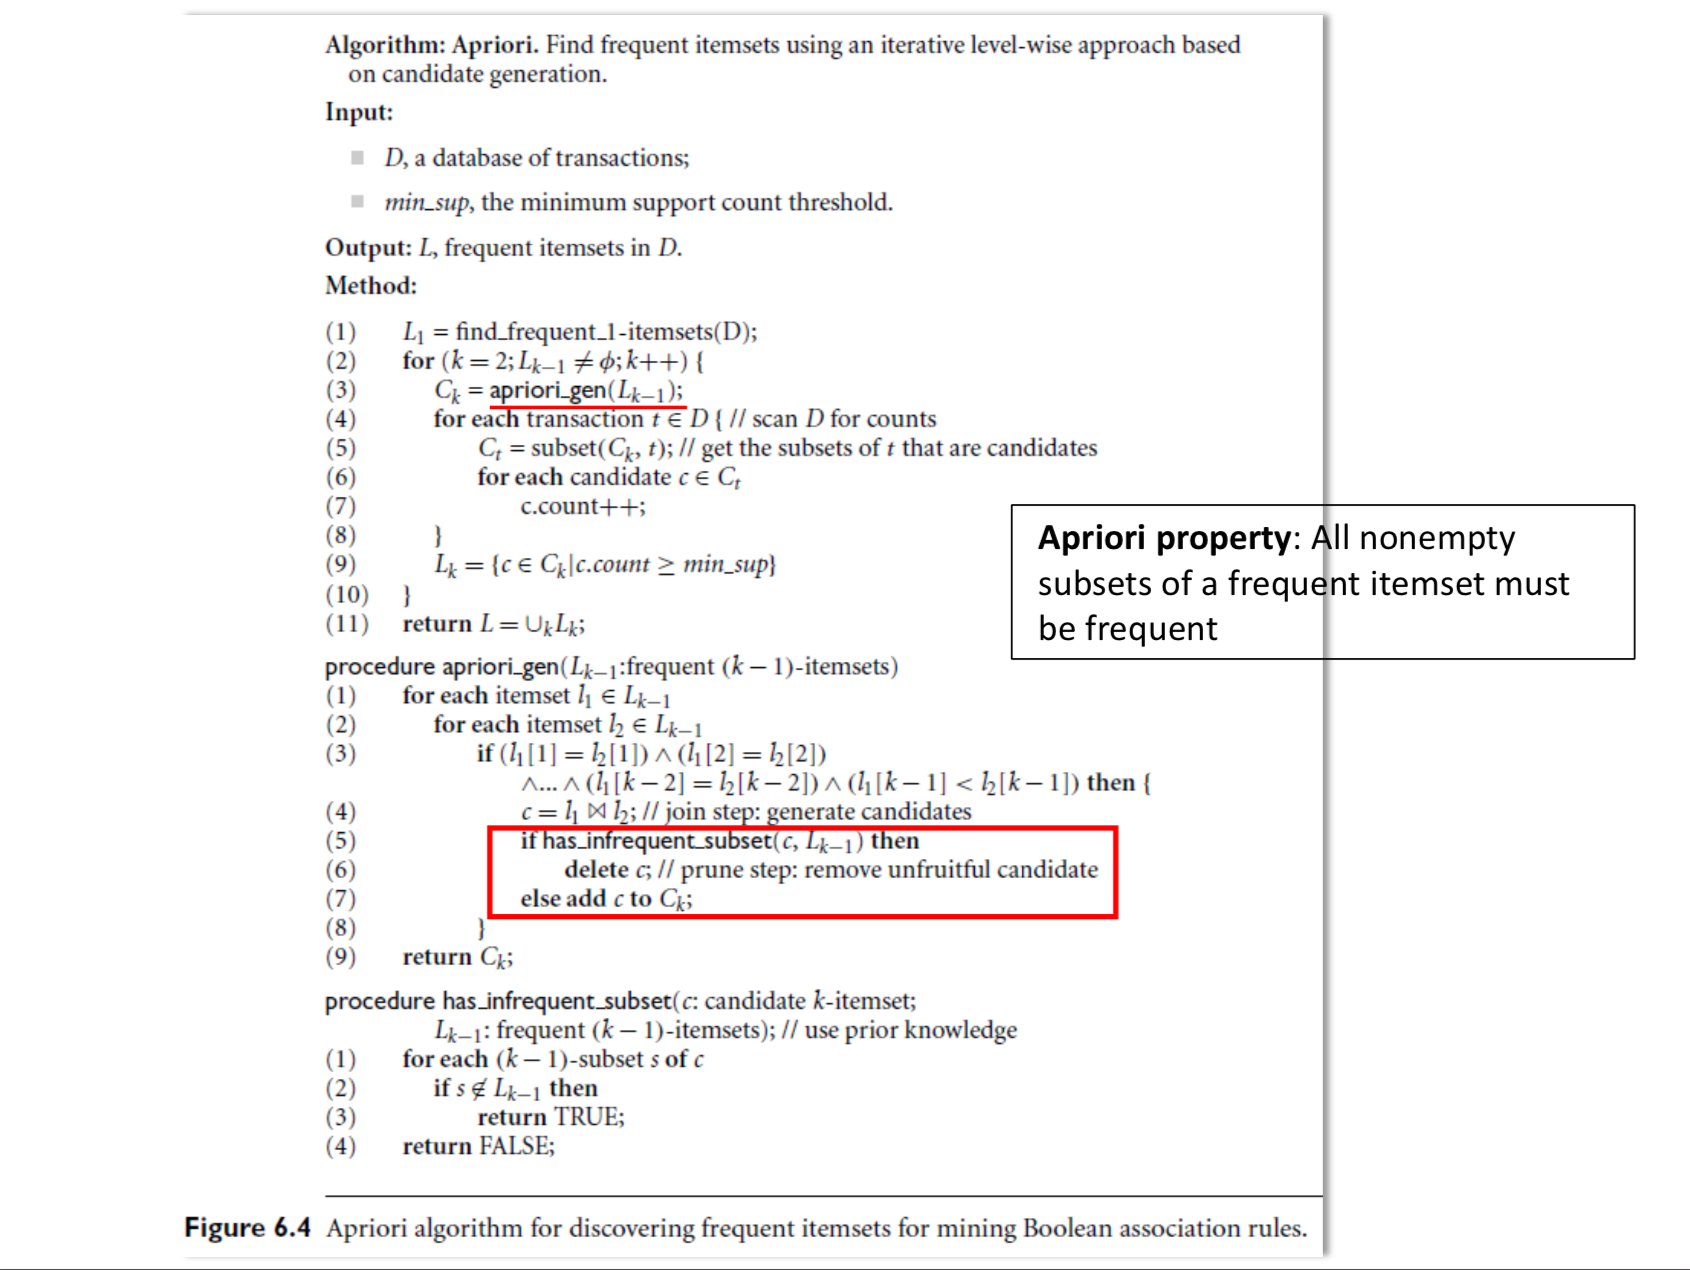